### Model Training

#### Imports

In [30]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input, Embedding, GlobalMaxPooling1D
from keras.models import load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/mariusaffolter/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/mariusaffolter/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mariusaffolter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/mariusaffolter/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Epoch 1/6
967/967 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - accuracy: 0.8247 - loss: 0.3138 - val_accuracy: 0.9787 - val_loss: 0.0607
Epoch 2/6
967/967 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - accuracy: 0.9869 - loss: 0.0444 - val_accuracy: 0.9816 - val_loss: 0.0555
Epoch 3/6
967/967 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - accuracy: 0.9962 - loss: 0.0155 - val_accuracy: 0.9812 - val_loss: 0.0634
Epoch 4/6
967/967 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - accuracy: 0.9982 - loss: 0.0065 - val_accuracy: 0.9811 - val_loss: 0.0991
Epoch 5/6
967/967 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - accuracy: 0.9989 - loss: 0.0058 - val_accuracy: 0.9814 - val_loss: 0.1157
Epoch 6/6
967/967 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - accuracy: 0.9995 - loss: 0.0022 - val_accuracy: 0.9785 - val_loss: 0.1119


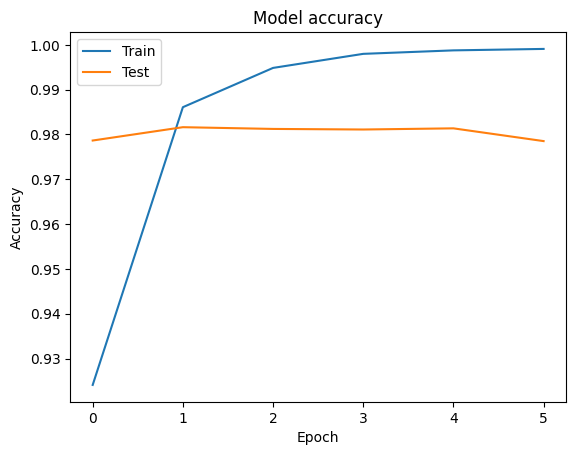

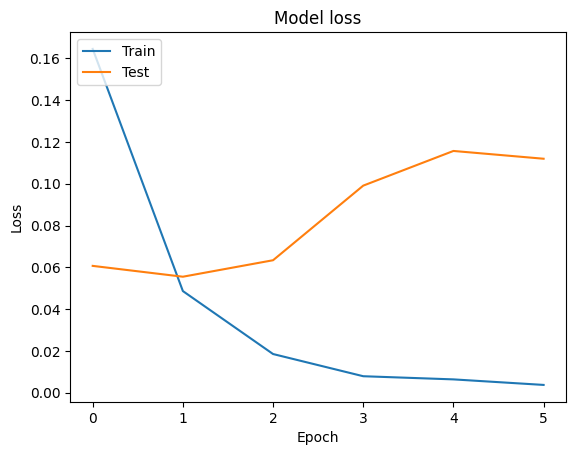

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step - accuracy: 0.9778 - loss: 0.1014
Test Loss: 0.11193734407424927
Test Accuracy: 0.9785252213478088
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


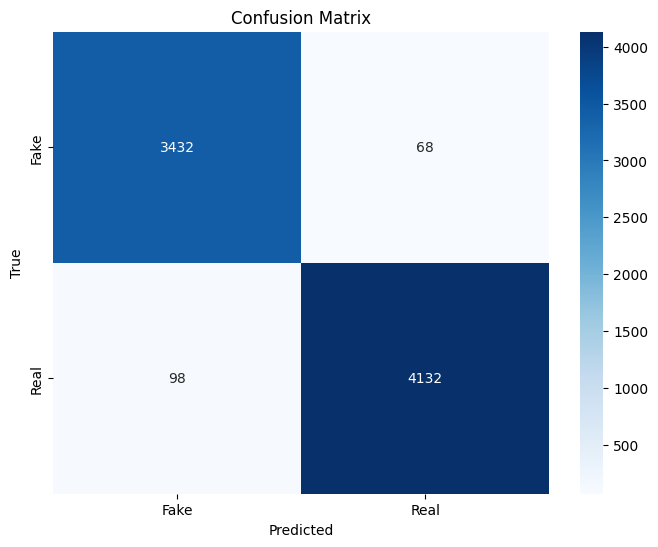

In [21]:
# Load the data
fake = pd.read_csv('./raw-data/raw-dataset-01/Fake.csv')
true = pd.read_csv('./raw-data/raw-dataset-01/True.csv')

# Give the fake news label 0
fake['label'] = 0

# Give the true news label 1
true['label'] = 1

# Drop unneeded columns
fake.drop(columns=["title", "date", "subject"], inplace=True)
true.drop(columns=["title", "date", "subject"], inplace=True)

# Combine the datasets
news = pd.concat([fake, true], ignore_index=True)

# Check for cleaning data
news.drop_duplicates(inplace=True)

# Preprocess the text data
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('punkt')

def process_text(text):
    text = re.sub(r'\s+', ' ', text, flags=re.I)
    text = re.sub(r'\W', ' ', str(text))
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    words = word_tokenize(text)
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    stop_words = set(stopwords.words("english"))
    words = [word for word in words if word not in stop_words]
    words = [word for word in words if len(word) > 3]
    indices = np.unique(words, return_index=True)[1]
    cleaned_text = np.array(words)[np.sort(indices)].tolist()
    return cleaned_text

# Separate the text and labels
x = news.drop('label', axis=1)
y = news.label

# Process the texts
texts = list(x['text'])
cleaned_text = [process_text(text) for text in texts]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(cleaned_text, y, test_size=0.2, random_state=42)

# Tokenize the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
word_idx = tokenizer.word_index
vocab_size = len(word_idx) + 1

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

maxlen = 150
X_train = pad_sequences(X_train, maxlen=maxlen)
X_test = pad_sequences(X_test, maxlen=maxlen)

# Encode the labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Convert labels to categorical format
y_train_one_hot = tf.keras.utils.to_categorical(y_train_encoded)
y_test_one_hot = tf.keras.utils.to_categorical(y_test_encoded)

# Build the ANN model
model = Sequential()
model.add(Input(shape=(maxlen,)))
model.add(Embedding(vocab_size, 100))
model.add(GlobalMaxPooling1D())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train_one_hot, epochs=6, validation_data=(X_test, y_test_one_hot), batch_size=32)

# Save the trained model
model.save('./models/model-v1.h5')

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test_one_hot)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

# Confusion matrix
y_pred_probs = model.predict(X_test)
y_pred_labels = np.argmax(y_pred_probs, axis=1)
y_true_labels = np.argmax(y_test_one_hot, axis=1)
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/mariusaffolter/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/mariusaffolter/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mariusaffolter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/mariusaffolter/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
                                                text predicted_label
0  **Landmark Trade Deal Reached Between Global P...            Fake
1  In a groundbreaking study released today by th...            Fake
2  In a stunning display of endurance and athleti...            Fake
3  In a shocking turn of events, a massive avalan...            Fake
4  In a historic economic development that has st...            Real


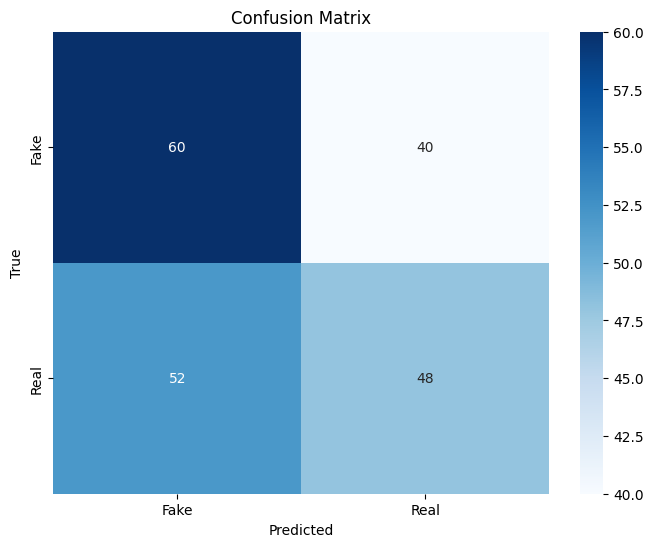

              precision    recall  f1-score   support

        Fake       0.54      0.60      0.57       100
        Real       0.55      0.48      0.51       100

    accuracy                           0.54       200
   macro avg       0.54      0.54      0.54       200
weighted avg       0.54      0.54      0.54       200



In [31]:
# Load the new datasets
generated_articles = pd.read_csv('./raw-data/generated-articles.csv')
scraped_articles = pd.read_csv('./raw-data/scraped-articles.csv')

# Assign labels to each dataset
generated_articles['label'] = 0
scraped_articles['label'] = 1

# Merge the datasets
new_data = pd.concat([generated_articles, scraped_articles], ignore_index=True)

# Check for cleaning data
new_data.drop_duplicates(inplace=True)

# Preprocess the text data
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('punkt')

def process_text(text):
    text = re.sub(r'\s+', ' ', text, flags=re.I)
    text = re.sub(r'\W', ' ', str(text))
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    words = word_tokenize(text)
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    stop_words = set(stopwords.words("english"))
    words = [word for word in words if word not in stop_words]
    words = [word for word in words if len(word) > 3]
    indices = np.unique(words, return_index=True)[1]
    cleaned_text = np.array(words)[np.sort(indices)].tolist()
    return cleaned_text

# Separate the text and labels
x_new = new_data.drop('label', axis=1)
y_new = new_data.label

# Process the texts
texts_new = list(x_new['text'])
cleaned_text_new = [process_text(text) for text in texts_new]

# Tokenize the new text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(cleaned_text_new)
word_idx = tokenizer.word_index
vocab_size = len(word_idx) + 1

new_sequences = tokenizer.texts_to_sequences(cleaned_text_new)

# Pad the sequences
maxlen = 150
new_padded_sequences = pad_sequences(new_sequences, maxlen=maxlen)

# Load the pre-trained model
model = load_model('./models/model-v1.h5')

# Make predictions on the new data
new_predictions = model.predict(new_padded_sequences)

# Convert prediction probabilities to class labels
new_pred_labels = np.argmax(new_predictions, axis=1)

# Decode the labels (assuming 0: Fake, 1: Real)
label_map = {0: 'Fake', 1: 'Real'}
new_pred_mapped_labels = [label_map[label] for label in new_pred_labels]

# Add predictions to the new data
new_data['predicted_label'] = new_pred_mapped_labels

# Save the predictions to a new CSV file
new_data.to_csv('./raw-data/predictions.csv', index=False)

print(new_data[['text', 'predicted_label']].head())

# Generate confusion matrix
conf_matrix = confusion_matrix(y_new, new_pred_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification report
report = classification_report(y_new, new_pred_labels, target_names=['Fake', 'Real'])
print(report)

In [9]:
import os
import platform
import socket
from platform import python_version
from datetime import datetime

print('-----------------------------------')
print(os.name.upper())
print(platform.system(), '|', platform.release())
print('Datetime:', datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
print('Python Version:', python_version())
print('-----------------------------------')

-----------------------------------
POSIX
Darwin | 23.5.0
Datetime: 2024-05-29 14:49:36
Python Version: 3.12.1
-----------------------------------
